In [1]:
%matplotlib notebook

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
import emcee
import corner
from scipy import signal

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


<IPython.core.display.Javascript object>


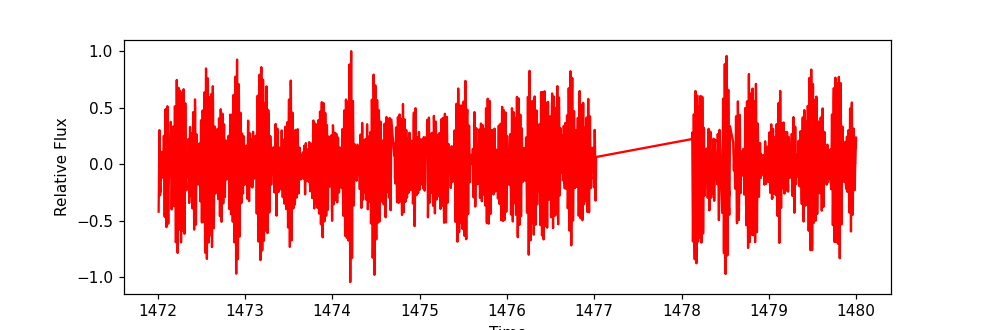

In [28]:
### TESS data import ###
data = np.loadtxt("TESS_data.dat",usecols=(0,1))
time = data[:,0]
index = np.argwhere((time>1472)&(time<1480))
time = np.ndarray.flatten(time[index])
# à prendre vers 1472
flux = data[:,1]
flux = np.ndarray.flatten(flux[index])
flux = (flux - np.mean(flux))/(np.max(flux)-np.mean(flux))


fig = plt.figure(figsize=(9,3))
ax = plt.gca()
#ax.scatter(time,flux,c="r",s=1)
ax.plot(time,flux,c="r")
ax.set_xlabel("Time")
ax.set_ylabel("Relative Flux")
fig.show()

In [29]:
freqs,amps,phases = np.loadtxt("TESS_freqs.txt",usecols=(1,2,3)).T
freqs_errors,amps_errors,phases_errors = np.loadtxt("TESS_freqs_errors.txt",usecols=(0,1,2)).T

In [30]:
# y = []
# y_error = []
# for i in time:
#     tmp = [] #saves one sine
#     tmp_error = []
#     for freq, amp, phase,freq_error,amp_error,phase_error in zip(freqs, amps, phases,freqs_errors, amps_errors, phases_errors):
# #    for freq_error,amp_error,phase_error in zip(freqs_errors, amps_errors, phases_errors):
#         tmp.append(amp * np.sin(2 * np.pi * freq * i + phase * 2 * np.pi))
#         tmp_error.append((amp+amp_error) * np.sin(2 * np.pi * (freq+freq_error) * i + (phase+phase_error) * 2 * np.pi))
#     y.append(np.sum(tmp))
#     y_error.append(np.sum(tmp_error))
# y = np.array(y)
# flux_error = np.array(y_error)

# y = (y - np.mean(y))/(np.max(y) - np.mean(y))
# flux_error = (flux_error - np.mean(flux_error))/(np.max(flux_error) - np.mean(flux_error))
# flux_error = y - flux_error

In [31]:
# plt.figure(figsize=(9,3))
# plt.plot(time,flux-flux_error)
# plt.show()

In [32]:
### GP Model ###
bounds = dict(log_S0= (-20,10), log_Q = (-10,10), log_omega0 = (5,7))
#kernel = terms.SHOTerm(log_S0=7., log_Q=2.5, log_omega0=5.)
kernel = terms.SHOTerm(log_S0=7., log_Q=2.5, log_omega0=5.,bounds=bounds)


gp = celerite.GP(kernel,mean=0.0)
gp.compute(time,yerr=0)

print("Initial log likelihood: {0}".format(gp.log_likelihood(flux)))
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))

Initial log likelihood: -22625.197870436623
parameter_dict:
OrderedDict([('kernel:log_S0', 7.0), ('kernel:log_Q', 2.5), ('kernel:log_omega0', 5.0)])



In [33]:
x = np.linspace(np.min(time),np.max(time),15000)
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

C:\ProgramData\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


<IPython.core.display.Javascript object>


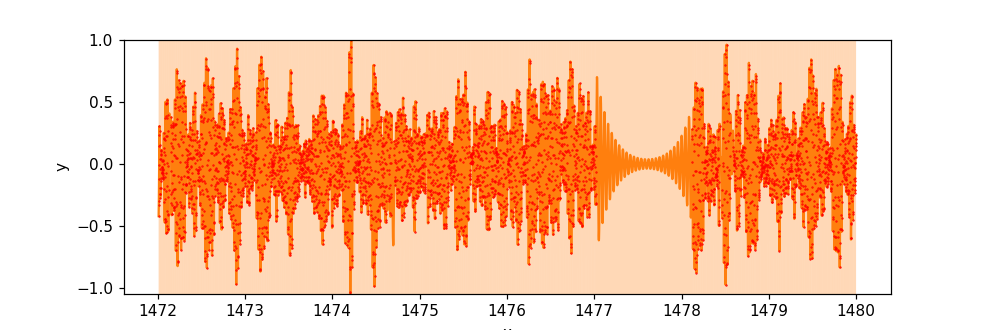

In [34]:
color = "#ff7f0e"
#plt.scatter(time,flux,c="r",s=1)
plt.figure(figsize=(9,3))
plt.errorbar(time,flux,yerr=0,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(flux),np.max(flux))
plt.show()

In [35]:
### Minimize ###
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)
# extract our initial guess at parameters
# from the celerite kernel and put it in a 
# vector:
p0 = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

# run optimization:
results = minimize(neg_log_like, p0, method='L-BFGS-B',bounds=bounds,args=(flux, gp))
print(results)
print("Final log-likelihood: {0}".format(-results.fun))
print(np.exp(results.x))
print("Parameters: {0}".format(gp.get_parameter_dict()))
gp.set_parameter_vector(results.x)

      fun: -6346.873817554652
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.54747351e-03, 4.54183464e+00, 5.06934157e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 180
      nit: 22
   status: 0
  success: True
        x: array([-8.90138562,  0.8034887 ,  5.80290879])
Final log-likelihood: 6346.873817554652
[1.36200074e-04 2.23331873e+00 3.31261732e+02]
Parameters: OrderedDict([('kernel:log_S0', -8.901385619224207), ('kernel:log_Q', 0.803488697705417), ('kernel:log_omega0', 5.802908803341038)])


In [36]:
### Prédiction avec les nouveaux paramètres calculés ###
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

<IPython.core.display.Javascript object>


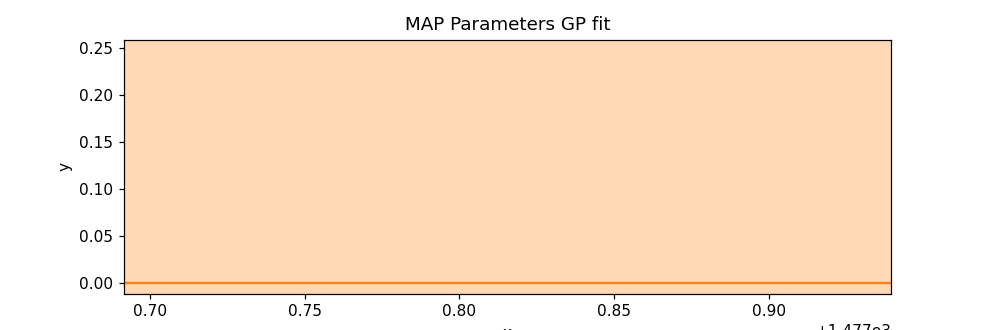

In [37]:
### Plot du posterior du minimize ###
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.errorbar(time,flux,yerr=0,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(flux),np.max(flux))
plt.title("MAP Parameters GP fit")
plt.show()
# plt.scatter(x,flux - pred_mean,c='k',s=1)
# plt.axhline(y=0,color='k')
# plt.title("Residuals")
# plt.show()

In [38]:
### Définition de la likelihood ###
def log_likelihood(params,time,flux):
    gp.set_parameter_vector(params)
    ll = gp.log_likelihood(flux)
    return ll if np.isfinite(ll) else -np.inf

In [39]:
### Définition du prior (uniforme) ###
def log_prior(params):
    if ((-20 < params[0] < 10) and (-10 < params[1] < 10) and (5 < params[2] < 7)) :
        return 0
    return -np.inf

In [40]:
### Définition du posterior ###
def log_probability(params,time,flux):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,time,flux) if np.isfinite(lp) else -np.inf

In [41]:
### MCMC ###
initial = np.array(results.x)
ndim, nwalkers = len(initial), 128
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,args=(time,flux))

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500,progress=True)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 5000,progress=True)
print("Finished")

  0%|          | 0/500 [00:00<?, ?it/s]

Running burn-in...


  0%|          | 0/5000 [00:00<?, ?it/s]

Running production...


100%|██████████| 5000/5000 [13:40<00:00,  6.09it/s]

Finished


In [42]:
print("Final MCMC Parameters: {0}".format(gp.get_parameter_dict()))
print("Final MCMC log likelihood: {0}".format(gp.log_likelihood(flux)))

Final MCMC Parameters: OrderedDict([('kernel:log_S0', -8.921633218213218), ('kernel:log_Q', 0.78316520739464), ('kernel:log_omega0', 5.807736849366377)])
Final MCMC log likelihood: 6346.561060825207


<IPython.core.display.Javascript object>


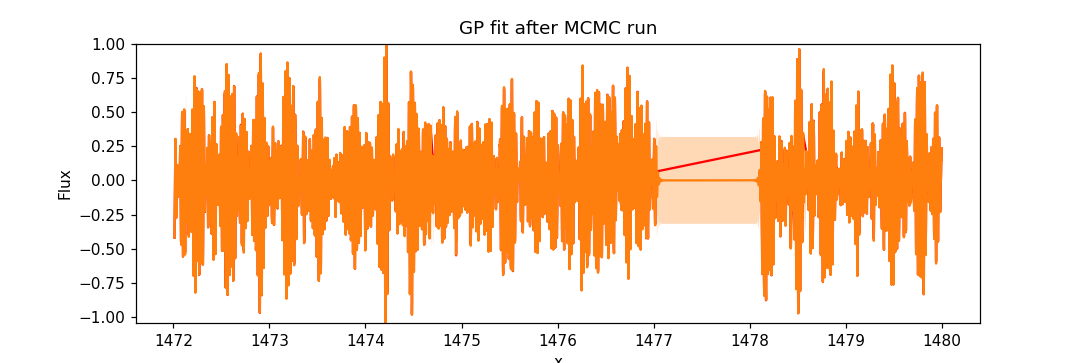

In [43]:
# Plot the data.

# Plot 24 posterior samples.
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.plot(time,flux,c="r")
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("Flux")
plt.ylim(np.min(flux),np.max(flux))
plt.title("GP fit after MCMC run")
plt.show()

In [44]:
w = np.exp(gp.get_parameter_vector())
print(w)
f = w[2]/(2*np.pi)
f

[1.33470081e-04 2.18838802e+00 3.32864949e+02]


52.977102026274025

In [45]:
P = 1/f
print("periode :",P*24*60,"min")

periode : 27.181554764657214 min


In [46]:
pred_mean, pred_var = gp.predict(flux, time, return_var=True)
pred_std = np.sqrt(pred_var)

C:\ProgramData\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


<IPython.core.display.Javascript object>


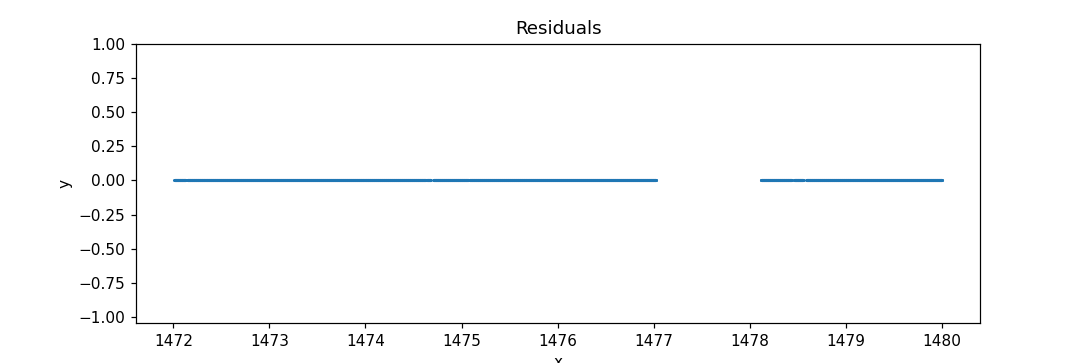

In [47]:
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.scatter(time,flux - pred_mean,s=1)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(flux),np.max(flux))
plt.title("Residuals")
plt.show()

<IPython.core.display.Javascript object>


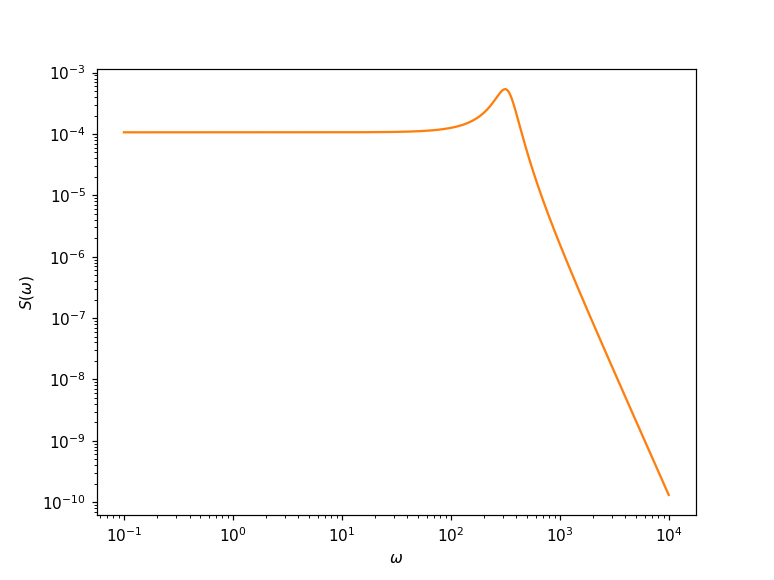

In [48]:
plt.figure()
omega = np.exp(np.linspace(np.log(0.1), np.log(10000), 5000))
psd = gp.kernel.get_psd(omega)
plt.plot(omega, psd, color=color)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$")
plt.show()

(41728, 3)


<IPython.core.display.Javascript object>


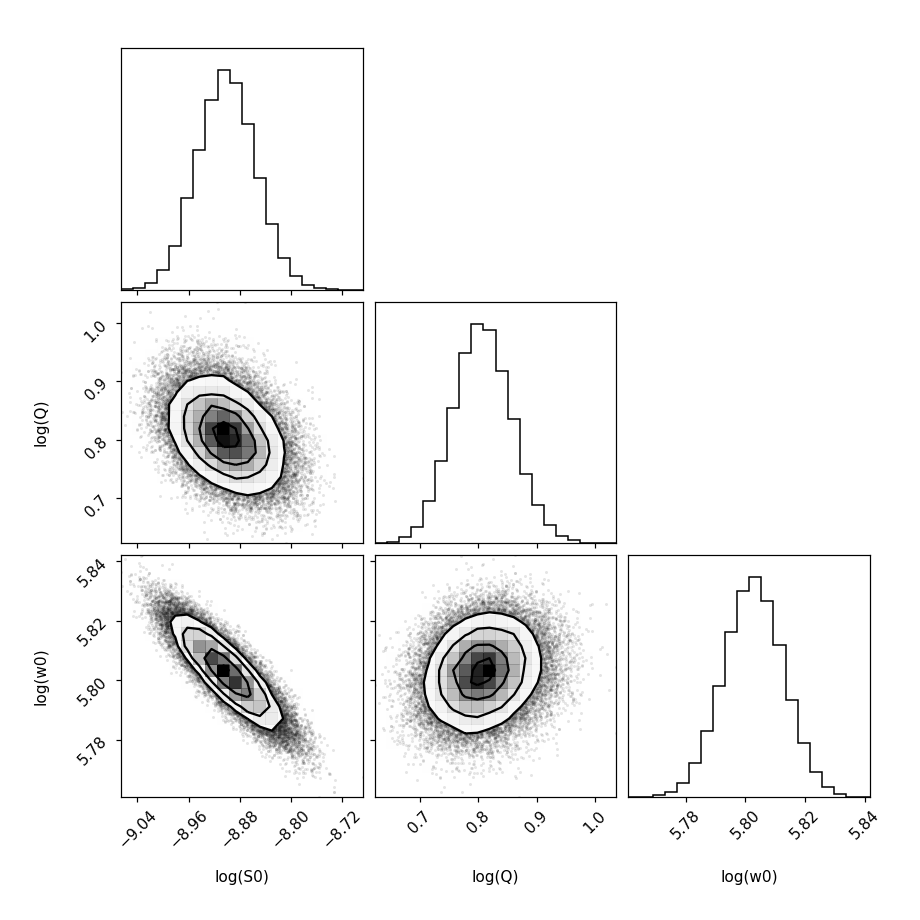

In [49]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
labels = ["log(S0)","log(Q)","log(w0)"]
fig = corner.corner(flat_samples, labels=labels, truths=[None,None,np.log(2*np.pi*24*60/30.4)])
plt.show()

In [50]:
tau = sampler.get_autocorr_time()
print(tau)

[35.95721988 36.37815484 35.50131813]


<IPython.core.display.Javascript object>


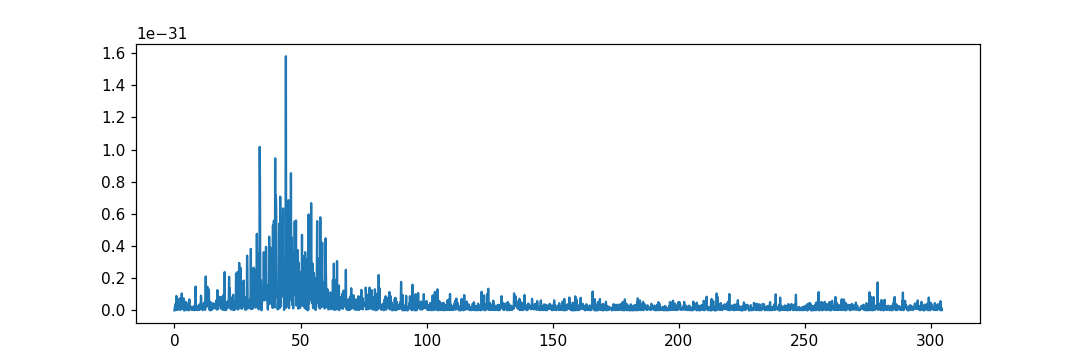

freq: 44.186602944466046 d-1
periode 32.589063291645196 min


In [51]:
fs = len(time)/(time[-1] - time[0])
f,pxx = signal.periodogram(flux - pred_mean,fs)
plt.figure(figsize=(9,3))
plt.plot(f,pxx)
plt.show()
idx = np.argmax(pxx)
print("freq:", f[idx],"d-1")
print("periode",1/f[idx]*60*24,"min")